# 환경 변수 세팅

In [2]:
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# torch: PyTorch. 딥러닝 및 텐서 연산을 위한 라이브러리. 인공지능 모델을 만들거나 불러와 추론하는 도구
# torchvision: 이미지 변환 및 전처리를 위한 torchvision의 transform 모듈
# deeplabv3_resnet101: 사전 학습된 DeepLabV3 모델. 이미지를 분류하도록 학습된 모델
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구

import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print('슝=3')

슝=3


이미지 크기: (1079, 1079, 3)


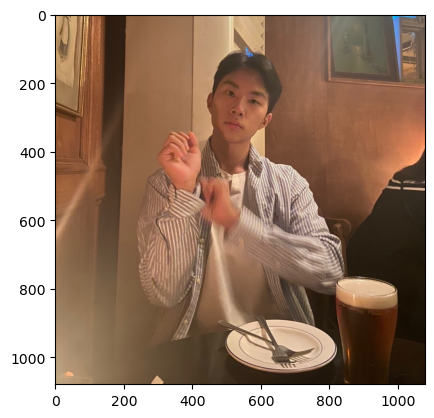

In [3]:
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장

home_dir = os.getenv('HOME')
img_path = os.path.join(home_dir, "work/human_segmentation/images/my_image.png")
img_orig = cv2.imread(img_path)

print(f"이미지 크기: {img_orig.shape}")

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
# dEEPLAB 모델 준비
model = deeplabv3_resnet101(pretrained=True).eval()

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기 (고정)
    T.ToTensor(),
])

In [6]:
input_tensor = transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

In [7]:
# 모델에 이미지 입력하기

%time
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)

CPU times: user 4 μs, sys: 1e+03 ns, total: 5 μs
Wall time: 11 μs


==================================================================================

PASCAL VOD 데이터로 학습된 모델을 사용할 것이다.

모델마다 학습시킨 데이터에 따라 결괏값이 달라지므로 어떤 데이터를 학습시켰는 지 '확인'하는 것이 중요하다.

In [8]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)
# Background를 제외하면 20개의 클래스가 있다.

21

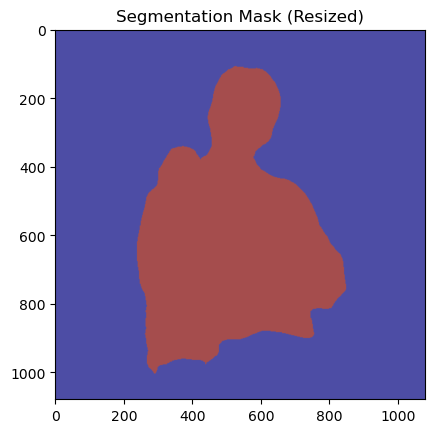

In [9]:
plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

In [10]:
unique_classes = np.unique(output_predictions_resized)
unique_classes

array([ 0, 15], dtype=uint8)

In [11]:
for class_id in unique_classes:
    print(LABEL_NAMES[class_id])

background
person


In [12]:
#컬러맵 만들기
# 출력물을 살펴보기

colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]  # 생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [13]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

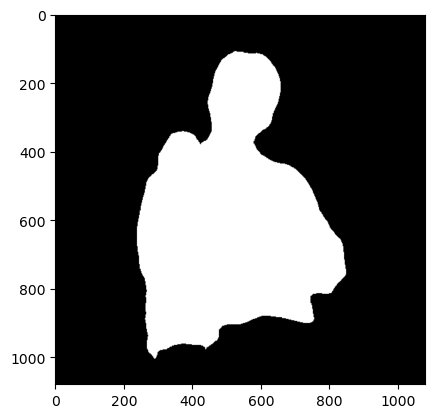

In [14]:
# output의 픽셀 별로 예측된 class가 사람이라면 1(True), 다르다면 0(False)이 된다.

# 1과 0에 각각 255를 곱하였으므로 사람으로 예측된 픽셀은 255, 그렇지 않은 픽셀은 0
# cmap 값을 변경하면 다른 색상으로 확인이 가능.

seg_map = (output_predictions_resized == 15)  # 클래스 ID 15 (사람)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')  # 흑백으로 표시
plt.show()

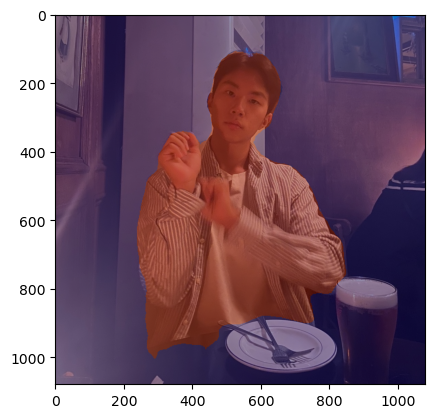

In [15]:
# 원본 이미지와 마스트를 적당히 합쳐본다.
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.

img_show = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

배경 흐리게 하기 blur()

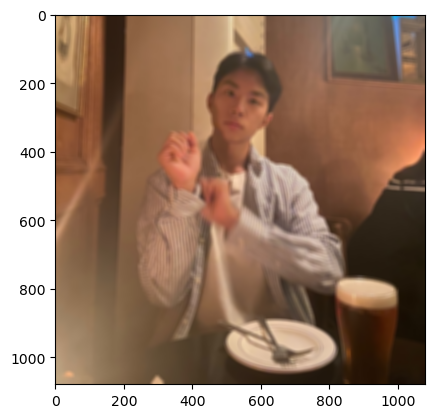

In [16]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔서 blur 강도를 조절할 수 있다.
img_orig_blur = cv2.blur(img_orig, (13, 13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

bitwise_not 함수를 이용하면 이미지가 반전된다.

원래 마스크에서는 배경이 0, 사람이 255였으니 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0이 되게 됨.

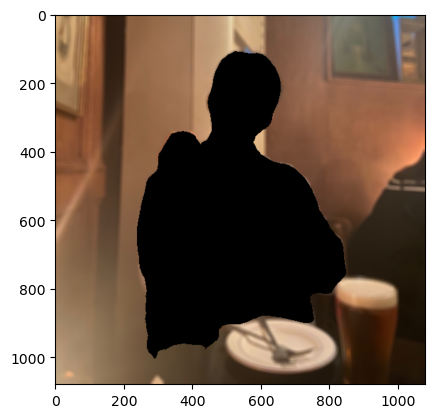

In [17]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0이 된다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 된다. 결국 사람이 사라지고 배경만 남게 됨!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 과제: 아웃포커싱 효과가 적용된 인물모드 사진
이제 흐린 배경과 원본 이미지를 합치기만 하면 된다.

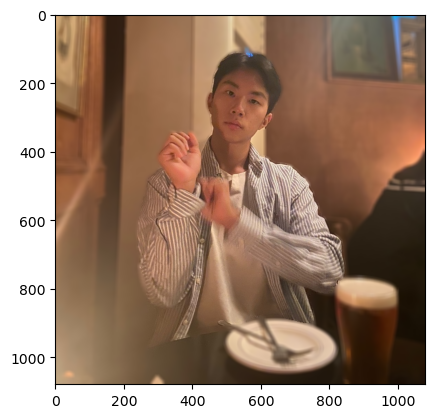

In [18]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고
# 아닌 영역은 블러된 이미지 값을 사용한다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

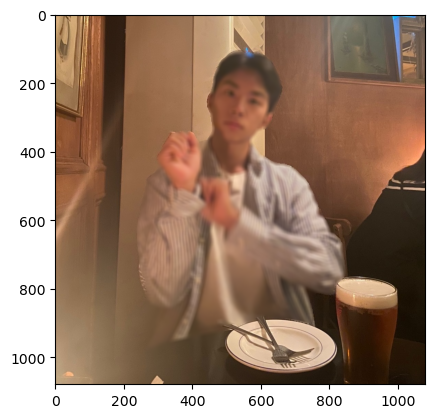

In [19]:
# 사람 부분을 블러로, 배경 부분을 원본으로 출력하기.
# img_mask_color 옵션을 적절히 조정해주고, img_orig, img_orig_blur 를 활용하면 된다.
img_concat = np.where(img_mask_color == 255, img_orig_blur, img_orig)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 인물 모드 문제점 찾기

원본 고양이 이미지 크기: (225, 224, 3)
배경(사막) 이미지 크기: (194, 259, 3)


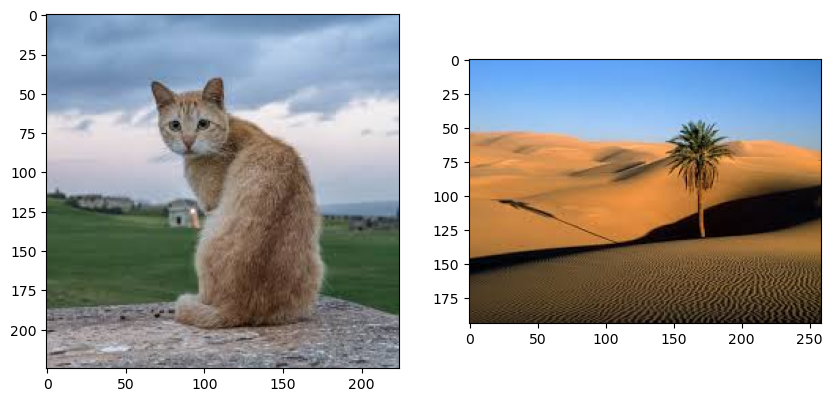

In [30]:
# 고양이와 사막 이미지 불러오기
home_dir = os.getenv('HOME')
cat_img_path = os.path.join(home_dir, "work/human_segmentation/images/cat.png")
sand_img_path = os.path.join(home_dir, "work/human_segmentation/images/sand.png")

cat_img = cv2.imread(cat_img_path)
sand_img = cv2.imread(sand_img_path)

cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

print(f"원본 고양이 이미지 크기: {cat_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

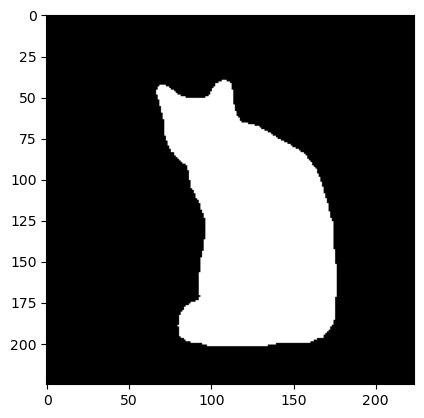

In [39]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

In [41]:
# 1. 배경 크기를 고양이 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))

# 2. 마스크를 3채널로 변환
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# 3. shape 확인
print(cat_img.shape)         
print(sand_img_resized.shape) 
print(img_mask_color.shape)   

# 4. np.where 적용
result_img = np.where(img_mask_color == 255, cat_img, sand_img_resized)


(225, 224, 3)
(225, 224, 3)
(225, 224, 3)


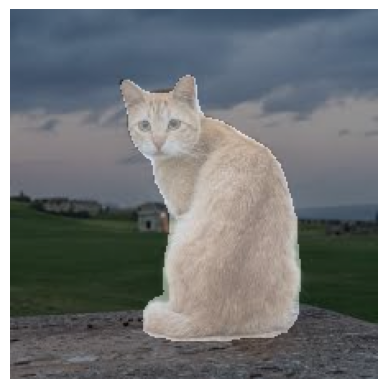

In [49]:
# 원본 이미지와 마스트를 적당히 합치기
# 0.6과 0.4는 두 이미지를 섞는 비율임.

cat_img = cat_img.astype(np.uint8)

img_show = cv2.addWeighted(cat_img, 0.6, color_mask, 0.4, 0.0)

plt.imshow(img_show)
plt.axis('off')
plt.show()

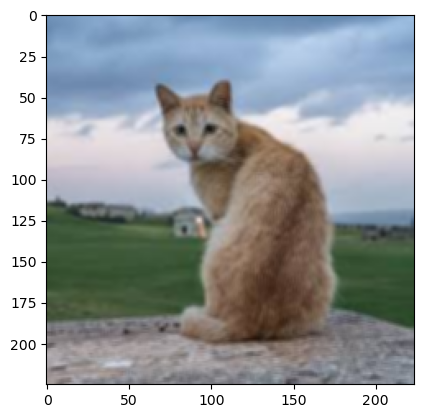

In [51]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
cat_img_blur = cv2.blur(cat_img, (3, 3))

plt.imshow(cat_img_blur)
plt.show()

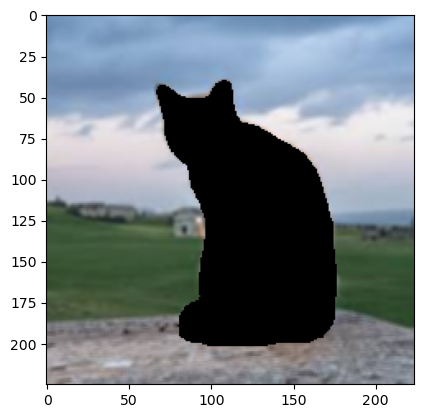

In [52]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전. 
# 배경이 0 고양이가 255이므로, 연산을 하고 나면 배경은 255 고양이가 0
img_bg_mask = cv2.bitwise_not(img_mask_color)

# 0인 경우에는 피사체가 있던 모든 픽셀이 0이 되어 배경만 남는다.
cat_img_bg_blur = cv2.bitwise_and(cat_img_blur, img_bg_mask)
plt.imshow(cat_img_bg_blur)
plt.show()

### 과제: 아웃포커싱 효과가 적용된 동물 사진

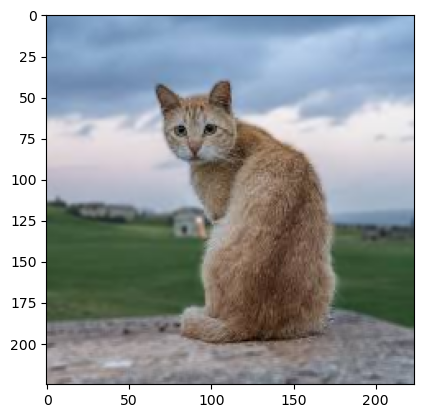

In [53]:
cat_img_concat = np.where(img_mask_color==255, cat_img, cat_img_bg_blur)

plt.imshow(cat_img_concat)
plt.show()

In [34]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor = transform(cat_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

추론 마스크 크기 (Before Resize): (520, 520)


In [35]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (225, 224)


In [36]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [0 8]


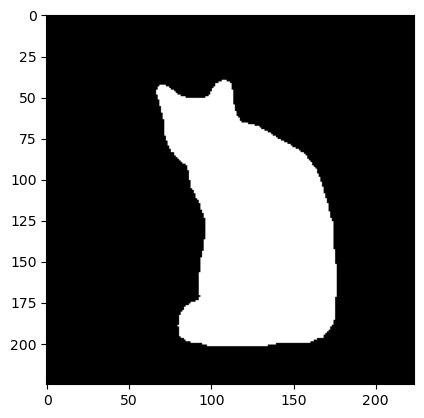

In [37]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

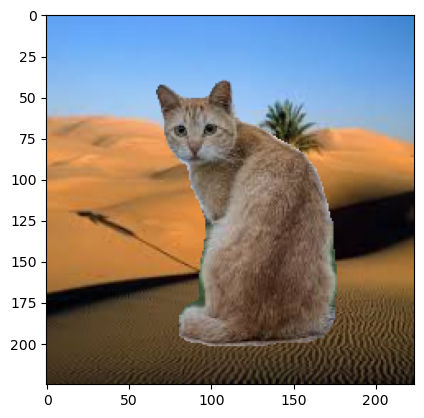

In [38]:
# 배경을 고양이 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))

# 고양이 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, cat_img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()

### 과제: 사진에서 문제점 지적하기

1. 고양이의 외곽부분에 초록 배경이 여전히 남아있다.
2. 고양이를 바라봤을 때 왼쪽에 위치한 귀가 조금 잘렸다.
3. 고양이를 바라봤을 때 왼쪽에 위치한 수염이 잘렸다.

<img src="human_segmentation/images/problem_result.png" width="400">


위 문제를 다르게 설명하자면, 다음 3가지 문제로 정의할 수 있다.

- 마스크 경계가 부정확하다.(귀가 잘리고, 이전 배경이 남는다)
- 작은 오브젝트 누락(수염)
- 배경과 피사체 경계가 불명확하다.

### 해결책 제안

1. 후처리 경계를 부드럽게 하는 Guided Filter 사용

🤔‘가이드 이미지(guide)’를 참고해 특정 이미지를 부드럽게(smooth) 만드는 필터
- 여기서 guide → cat_img (원본 고양이 사진)
- src → mask_float (DeepLab 같은 segmentation 모델이 만든 마스크)
- Guided Filter는 원본 이미지(cat_img) 를 참고해서, 경계선을 살려주면서 마스크의 내부를 부드럽게 스무딩한다.

🤔 원리 이해하기
- guide image(cat)을 보고 색이 급변하면 경계를 인식한다.
- 경계는 보존하고, 경계 안쪽을 부드럽게 스무딩한다.
- 이를 통해 헤어라인, 수염, 귀 같은 경계를 지킬 수 있다.

2. 모델 교체하기

DeepLab v3는 Encoder를 사용해서 이미지를 feature map으로 변환하고, 단순히 upsampling했다.

그러다보니까, 경계가 흐릿하거나 디테일에 약하다.

반면 Decoder를 추가한 DeepLab v3+는 Decoder에서 convolution과 upsampling으로 더 선명하게 segmentation한다.

이로 인해 v3+를 사용하면 더 정교한 segmentation이 가능해질 것이다.